#Data Cleaning

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

#AIR QUALITY DATA AND WEATHER DATA COLLECTION

Here we must first read in several different csv files, one for each pollutant and one for each weather measurement. There are files from PM2.5_frmfem, PM2.5_no_frmfem, PM10, Air Pressure, Relative Humidity, Dew Point, Temperature, Wind, CO, NO2, SO2, and Ozone.

In [2]:
#Function to get seasonal breadowns. Takes in
#a row from one of these csvs and splits the date
#column converting it to a datetime.
import datetime
def seasonMaker(rowIn):
    listeddate=[int(x) for x in rowIn.split("-")]
    dateInd = datetime.date(listeddate[0],listeddate[1],listeddate[2])
    if (dateInd <= datetime.date(2014,3,20)) or (dateInd >= datetime.date(2014,12,21)):
        return 'Winter'
    elif (dateInd <= datetime.date(2014,6,21)) and (dateInd >= datetime.date(2014,3,21)):
        return 'Spring'
    elif (dateInd <= datetime.date(2014,9,21)) and (dateInd >= datetime.date(2014,6,22)):
        return 'Summer'
    elif (dateInd <= datetime.date(2014,12,20)) and (dateInd >= datetime.date(2014,9,22)):
        return 'Fall'

In [3]:
#A similar function to the above, but it assigns month rather than season
def monthMaker(rowIn):
    listeddate=[int(x) for x in rowIn.split("-")]
    return listeddate[1]

Starting with PM2.5_frmfem. We need to make our base dataframe first and will use this particular csv to do so. We want to make 2 dataframe, `pollDat_s` and `pollDat_m`. One is aggregated at the seasonal level and one is aggregated at the month level. Daily observations are too variable to get an overall image.

**Read in all files**

In [4]:
#PM2.5_frmfem
pm25_frmfem = pd.read_csv("tempdata/pm2.5frmfem_2014.csv")
pm25_frmfem['season']=pm25_frmfem.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm25_frmfem['month']=pm25_frmfem.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PM2.5_no_frmfem
pm25_nofrmfem = pd.read_csv("tempdata/pm2.5_non_frmfem_2014.csv")
pm25_nofrmfem['season']=pm25_nofrmfem.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm25_nofrmfem['month']=pm25_nofrmfem.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PM10
pm10 = pd.read_csv("tempdata/pm10_2014.csv")
pm10['season']=pm10.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm10['month']=pm10.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#TEMP
temp = pd.read_csv("tempdata/temp_2014.csv")
temp['season']=temp.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
temp['month']=temp.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PRESS
press = pd.read_csv("tempdata/press_2014.csv")
press['season']=press.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
press['month']=press.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#RH_DP
rh_dp = pd.read_csv("tempdata/rh_dp_2014.csv")
rh_dp['season']=rh_dp.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
rh_dp['month']=rh_dp.apply(lambda row: monthMaker(row['Date Local']), axis=1)
rh = rh_dp[rh_dp['Parameter Name']=='Relative Humidity ']
dp = rh_dp[rh_dp['Parameter Name']=='Dew Point']
#WIND
wind = pd.read_csv("tempdata/wind_2014.csv")
wind['season']=wind.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
wind['month']=wind.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#CO
co = pd.read_csv("tempdata/co_2014.csv")
co['season']=co.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
co['month']=co.apply(lambda row: monthMaker(row['Date Local']), axis=1)
co = co[co['Pollutant Standard']=='CO 8-hour 1971']
#NO2
no2 = pd.read_csv("tempdata/no2_2014.csv")
no2['season']=no2.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
no2['month']=no2.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#OZONE
ozone = pd.read_csv("tempdata/ozone_2014.csv")
ozone['season']=ozone.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
ozone['month']=ozone.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#SO2
so2 = pd.read_csv("tempdata/so2_2014.csv")
so2['season']=so2.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
so2['month']=so2.apply(lambda row: monthMaker(row['Date Local']), axis=1)
so2 = so2[so2['Pollutant Standard']=='SO2 1-hour 2010']

Get all the possible Core-Based Statistical Areas (CBSA). These are used for census data of all areas connected to a metropolitan area or micropolitan area.

In [5]:
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
uniqueCBSA = np.array([])
for f in fileList:
    uniqueCBSA= np.append(uniqueCBSA,f['CBSA Name'].unique())
uniqueCBSA = set(uniqueCBSA)
print "Number of unique CBSA in all files: "+str(len(uniqueCBSA))

Number of unique CBSA in all files: 536


In [6]:
out = pd.DataFrame(list(uniqueCBSA))
out.to_csv("tempdata/UniqueCBSAList.csv")

What about the ones that didn't have a CBSA identifier? How many were there and what Site Location were they?

In [7]:
numDup = pd.DataFrame(columns=['Local Site Name','State Name','County Name','City Name'])
for f in fileList:
    a=f[pd.isnull(f['CBSA Name'])]
    names = a.ix[:,['Local Site Name','State Name','County Name','City Name']]
    names = names.drop_duplicates()
    numDup = pd.concat([numDup,names])
print "Number of Sites with no CBSA: " +str(len(numDup.drop_duplicates()))

Number of Sites with no CBSA: 301


##COLLECTING DEMOGRAPHICS

To make our lives easy and to make it a little easier to interpret. We still have decent coverage of the US with these so it should lead to interpretable results. Next we'd like to be able to pull population density information and other info in for these CBSA ids. This requires another data set from http://www.census.gov/population/metro/data/pop_data.html. This data is from 2010, but even though we're looking at 2014 weather/air quality data, it shouldn't have changed too dramatically in 4 years.

In [8]:
densityFile = pd.read_csv('tempdata/CBSA_density.csv')

In [9]:
#Removing top bad rows, removing bad columns, renaming columns
densityFile.drop(densityFile.index[[0,1,2,3,4,5,6,7]],inplace=True)
densityFile.drop(densityFile.columns[[3,6,8,10]],axis=1,inplace=True)
densityFile.columns=['id','name','MetArea','pop2010','landarea','popdense2010','pop_weight2010']

In [10]:
densityFile.head()

,id,name,MetArea,pop2010,landarea,popdense2010,pop_weight2010
8,10180,"Abilene, TX",Metropolitan Statistical Area,"165,252","2,743.5",60.2,"1,771.8"
9,10420,"Akron, OH",Metropolitan Statistical Area,"703,200",900.1,781.2,"2,412.8"
10,10500,"Albany, GA",Metropolitan Statistical Area,"157,308","1,932.6",81.4,922.7
11,10580,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,"870,716","2,811.6",309.7,"2,944.9"
12,10740,"Albuquerque, NM",Metropolitan Statistical Area,"887,077","9,282.5",95.6,"3,518.6"


This file has the latitude and longitude data we'll want to use for each region. We need to merge this all together.

In [11]:
latlong = pd.read_csv('tempdata/CBSA_Chapter1PrinCities.csv')

This file has a lot of problems in the way information is provided. We want info for just the individual regions but there are a lot of NaNs. This is because only the primary city of a region gets the label. So we need to clean that up a bit. 

In [12]:
#Removing top bad rows, removing bad columns, renaming columns
latlong.drop(latlong.index[[0,1,2,3,4]],inplace=True)
latlong.drop(latlong.columns[[1,4]],axis=1,inplace=True)
latlong.columns=['id','name','pop2010','latitude','longitude']

In [13]:
#Get latitude and longitude for each id
group = latlong.groupby('id')
#Get rid of all the NaNs
#Help from 
#http://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-of-certain-column-is-nan
newdf=group.max()
newdf = newdf[pd.notnull(newdf['latitude'])]
#Weird anomaly
newdf.drop(newdf.index[6],inplace=True)

In [14]:
newdf['id']=newdf.index
newdf.head()

,name,pop2010,latitude,longitude,id
id,,,,,
10180,"Abilene, TX Metro Area","165,252",32.4519790,-99.7327870,10180
10420,"Akron, OH Metro Area","703,200",41.0805750,-81.5180690,10420
10500,"Albany, GA Metro Area","77,434",31.5783550,-84.1525160,10500
10580,Troy city,"97,856",42.6517310,-73.7551670,10580
10740,"Albuquerque, NM Metro Area","887,077",35.0879680,-106.6504030,10740


In [15]:
#Make a mapper to get numerical id for CBSA
idmapper = {}
for id, name in zip(densityFile.id,densityFile.name):
    idmapper[name]=id

In [16]:
#Set up the dictionary base
#The first entry in uniqueCBSA is NaN so we want
#to remove that
myFrame = pd.DataFrame({'name':list(uniqueCBSA)[1:]})
#Add numerical label 
myFrame['id']=myFrame['name'].map(idmapper.get)
myFrame.head()

,name,id
0,"Kahului-Wailuku, HI",27980
1,"Rapid City, SD",39660
2,"Seymour, IN",42980
3,"Fort Wayne, IN",23060
4,"Napa, CA",34900


In [17]:
#Deal with missing numerical labels case-by-case...
#Painful, but doable
a = myFrame[pd.isnull(myFrame['id'])]
print "Number of cities without numerical ID match: "+str(len(a))
a

Number of cities without numerical ID match: 24


,name,id
17,"Wenatchee, WA",None
35,"San Antonio, TX",None
48,"Portland-Vancouver-Beaverton, OR-WA",None
107,"Bradenton-Sarasota-Venice, FL",None
111,"Madera, CA",None
115,"Atlantic City, NJ",None
141,"Weirton-Steubenville, WV-OH",None
146,"Chicago-Naperville-Joliet, IL-IN-WI",None
158,"Bakersfield, CA",None
171,"Durham, NC",None


In [18]:
badmatch = {'Wenatchee, WA':'Wenatchee-East Wenatchee, WA','San Antonio, TX':'San Antonio-New Braunfels, TX',
           'Portland-Vancouver-Beaverton, OR-WA':'Portland-Vancouver-Hillsboro, OR-WA','Bradenton-Sarasota-Venice, FL':'North Port-Bradenton-Sarasota, FL',
           'Madera, CA':'Madera-Chowchilla, CA','Atlantic City, NJ':'Atlantic City-Hammonton, NJ','Weirton-Steubenville, WV-OH':'Steubenville-Weirton, OH-WV',
           'Chicago-Naperville-Joliet, IL-IN-WI':'Chicago-Joliet-Naperville, IL-IN-WI','Bakersfield, CA':'Bakersfield-Delano, CA',
           'Durham, NC':'Durham-Chapel Hill, NC','Mayaguez, PR':'Mayag\xfcez, PR','Kennewick-Richland-Pasco, WA':'Kennewick-Pasco-Richland, WA',
           'Canon City, CO':'Ca\xf1on City, CO','Lakeland, FL':'Lakeland-Winter Haven, FL','Orlando-Kissimmee, FL':'Orlando-Kissimmee-Sanford, FL',
           'Phoenix-Mesa-Scottsdale, AZ':'Phoenix-Mesa-Glendale, AZ','Nashville-Davidson-Murfreesboro-Franklin, TN':'Nashville-Davidson--Murfreesboro--Franklin, TN',
           'Charlotte-Gastonia-Concord, NC-SC':'Charlotte-Gastonia-Rock Hill, NC-SC','Washington Court House, OH, AR':'Washington Court House, OH',
           'Panama City-Lynn Haven, FL':'Panama City-Lynn Haven-Panama City Beach, FL','Fort Walton Beach-Crestview-Destin, FL':'Crestview-Fort Walton Beach-Destin, FL',
           'Austin-Round Rock, TX':'Austin-Round Rock-San Marcos, TX','Charleston-North Charleston, SC':'Charleston-North Charleston-Summerville, SC',
           'Denver-Aurora, CO':'Denver-Aurora-Broomfield, CO'}

In [19]:
#Update the mapper with these added entries
idmapper2 = idmapper.copy()
idmapper2.update(badmatch)

In [20]:
#Rerun the mapping afresh
myFrame = pd.DataFrame({'name':list(uniqueCBSA)[1:]})
#Add numerical label 
myFrame['id']=myFrame['name'].map(idmapper2.get)
myFrame.head()

,name,id
0,"Kahului-Wailuku, HI",27980
1,"Rapid City, SD",39660
2,"Seymour, IN",42980
3,"Fort Wayne, IN",23060
4,"Napa, CA",34900


In [21]:
#Check the dataframe
a = myFrame[pd.isnull(myFrame['id'])]
print "Number of cities without numerical ID match: "+str(len(a))

Number of cities without numerical ID match: 0


In [22]:
myFrame.merge(newdf,on='id',how='left').head()

,name_x,id,name_y,pop2010,latitude,longitude
0,"Kahului-Wailuku, HI",27980,NaN,NaN,NaN,NaN
1,"Rapid City, SD",39660,"Rapid City, SD Metro Area","67,956",44.0830460,-103.2262970
2,"Seymour, IN",42980,NaN,NaN,NaN,NaN
3,"Fort Wayne, IN",23060,"Fort Wayne, IN Metro Area","416,257",41.0805560,-85.1391380
4,"Napa, CA",34900,"Napa, CA Metro Area","76,915",38.2966540,-122.2900950


In [23]:
#Add latitude longitude
intermediate = myFrame.merge(newdf,on='id',how='left')
intermediate.drop(intermediate.columns[2],axis=1,inplace=True)

In [24]:
#Add population density
DemoFrame = intermediate.merge(densityFile,on='id',how='left')
DemoFrame.drop(DemoFrame.columns[[0,2]],axis=1,inplace=True)
DemoFrame.columns=['id','latitude','longitude','name','MetArea','pop2010','landarea','popdense2010','pop_weight2010']
DemoFrame.head()

,id,latitude,longitude,name,MetArea,pop2010,landarea,popdense2010,pop_weight2010
0,27980,NaN,NaN,"Kahului-Wailuku, HI",Micropolitan Statistical Area,"154,834","1,161.5",133.3,"2,310.8"
1,39660,44.0830460,-103.2262970,"Rapid City, SD",Metropolitan Statistical Area,"126,382","6,247.5",20.2,"1,170.8"
2,42980,NaN,NaN,"Seymour, IN",Micropolitan Statistical Area,"42,376",509.3,83.2,784.2
3,23060,41.0805560,-85.1391380,"Fort Wayne, IN",Metropolitan Statistical Area,"416,257","1,361.0",305.9,"1,964.2"
4,34900,38.2966540,-122.2900950,"Napa, CA",Metropolitan Statistical Area,"136,484",748.4,182.4,"4,045.9"


##MERGING DEMOGRAPHICS, AIR QUALITY, AND WEATHER

What we need to do here is aggregate information across all these files. This is all *daily* information. So that's the first challenge. We will work with just the average daily readings to begin with. The we want to aggreate daily measurements at a location to average monthly readings at a location and average seasonal readings at a location. This may not be the *most* robust strategy, but it will hopefully give a good starting point.

In [69]:
#DOING SEASONAL AVERAGING FIRST
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
fileName = ['PM25_FRMFEM','PM25_NOFRMFEM','PM10','TEMP','PRESS','RH','DP','WIND','CO','NO2','OZONE','SO2']
count = 0
for f,n in zip(fileList,fileName):
    if count == 0:
        group = f.groupby(['CBSA Name','season'])
        means = group.mean()
        means.drop(means.columns[[0,1,2,3,4,7,8,10,11,13]],axis=1,inplace=True)
        means.reset_index()
        means.reset_index(inplace=True)
        means.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
    else:
        group = f.groupby(['CBSA Name','season'])
        toAdd = group.mean()
        toAdd = pd.DataFrame(toAdd, columns=['Arithmetic Mean','AQI'])
        toAdd.reset_index()
        toAdd.reset_index(inplace=True)
        toAdd.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
        means = pd.merge(means,toAdd.reset_index(),on=['CBSA Name','season'],how='outer').reset_index()
        means.drop(['level_0','index'],axis=1,inplace=True)
    count += 1
means.drop(['month'],axis=1,inplace=True)

In [72]:
means['id']=means['CBSA Name'].map(idmapper2.get)

In [73]:
SeasonDat = means[means['id'].isin(myFrame['id'])]

In [74]:
SeasonDat.shape

(2104, 29)

In [75]:
print "# of Cities with Winter Data: "+str(SeasonDat[SeasonDat['season']=='Winter'].shape[0])
print "# of Cities with Summer Data: "+str(SeasonDat[SeasonDat['season']=='Summer'].shape[0])
print "# of Cities with Spring Data: "+str(SeasonDat[SeasonDat['season']=='Spring'].shape[0])
print "# of Cities with Fall Data: "+str(SeasonDat[SeasonDat['season']=='Fall'].shape[0])

# of Cities with Winter Data: 519
# of Cities with Summer Data: 530
# of Cities with Spring Data: 529
# of Cities with Fall Data: 526


In [85]:
#DOING MONTHLY AVERAGING SECOND
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
fileName = ['PM25_FRMFEM','PM25_NOFRMFEM','PM10','TEMP','PRESS','RH','DP','WIND','CO','NO2','OZONE','SO2']
count = 0
for f,n in zip(fileList,fileName):
    if count == 0:
        group = f.groupby(['CBSA Name','month'])
        means = group.mean()
        means.drop(means.columns[[0,1,2,3,4,7,8,10,11,13]],axis=1,inplace=True)
        means.reset_index()
        means.reset_index(inplace=True)
        means.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
    else:
        group = f.groupby(['CBSA Name','month'])
        toAdd = group.mean()
        toAdd = pd.DataFrame(toAdd, columns=['Arithmetic Mean','AQI'])
        toAdd.reset_index()
        toAdd.reset_index(inplace=True)
        toAdd.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
        means = pd.merge(means,toAdd.reset_index(),on=['CBSA Name','month'],how='outer').reset_index()
        means.drop(['level_0','index'],axis=1,inplace=True)
    count += 1
means['id']=means['CBSA Name'].map(idmapper2.get)
MonthDat = means[means['id'].isin(myFrame['id'])]
MonthDat.shape

(6217, 29)

In [86]:
print "# of Cities with January Data: "+str(MonthDat[MonthDat['month']==1].shape[0])
print "# of Cities with February Data: "+str(MonthDat[MonthDat['month']==2].shape[0])
print "# of Cities with March Data: "+str(MonthDat[MonthDat['month']==3].shape[0])
print "# of Cities with April Data: "+str(MonthDat[MonthDat['month']==4].shape[0])
print "# of Cities with May Data: "+str(MonthDat[MonthDat['month']==5].shape[0])
print "# of Cities with June Data: "+str(MonthDat[MonthDat['month']==6].shape[0])
print "# of Cities with July Data: "+str(MonthDat[MonthDat['month']==7].shape[0])
print "# of Cities with August Data: "+str(MonthDat[MonthDat['month']==8].shape[0])
print "# of Cities with September Data: "+str(MonthDat[MonthDat['month']==9].shape[0])
print "# of Cities with October Data: "+str(MonthDat[MonthDat['month']==10].shape[0])
print "# of Cities with November Data: "+str(MonthDat[MonthDat['month']==11].shape[0])
print "# of Cities with December Data: "+str(MonthDat[MonthDat['month']==12].shape[0])

# of Cities with January Data: 507
# of Cities with February Data: 510
# of Cities with March Data: 522
# of Cities with April Data: 527
# of Cities with May Data: 528
# of Cities with June Data: 528
# of Cities with July Data: 527
# of Cities with August Data: 530
# of Cities with September Data: 524
# of Cities with October Data: 521
# of Cities with November Data: 497
# of Cities with December Data: 496


In [87]:
SeasonDat.head()
DemoFrame.head()

,id,latitude,longitude,name,MetArea,pop2010,landarea,popdense2010,pop_weight2010
0,27980,NaN,NaN,"Kahului-Wailuku, HI",Micropolitan Statistical Area,"154,834","1,161.5",133.3,"2,310.8"
1,39660,44.0830460,-103.2262970,"Rapid City, SD",Metropolitan Statistical Area,"126,382","6,247.5",20.2,"1,170.8"
2,42980,NaN,NaN,"Seymour, IN",Micropolitan Statistical Area,"42,376",509.3,83.2,784.2
3,23060,41.0805560,-85.1391380,"Fort Wayne, IN",Metropolitan Statistical Area,"416,257","1,361.0",305.9,"1,964.2"
4,34900,38.2966540,-122.2900950,"Napa, CA",Metropolitan Statistical Area,"136,484",748.4,182.4,"4,045.9"


In [88]:
#Merge in demographic info
SeasonDat = SeasonDat.merge(DemoFrame[['id','MetArea','pop2010','landarea','popdense2010','pop_weight2010']],on='id',how='left')
MonthDat = MonthDat.merge(DemoFrame[['id','MetArea','pop2010','landarea','popdense2010','pop_weight2010']],on='id',how='left')

##BASIC DESCRIPTIVE VISUALIZATIONS

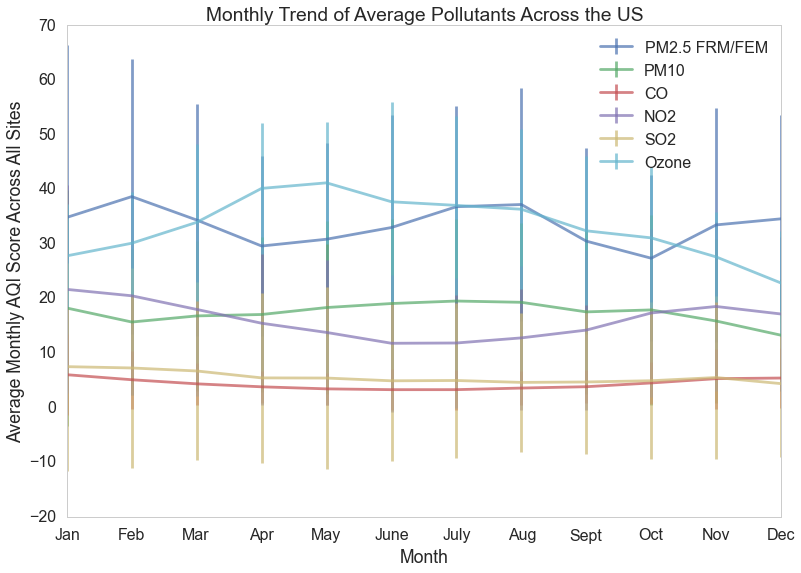

In [112]:
#Visualize the average pollutants monthly
group = MonthDat.groupby('month')
plotVals = group.mean()
plotError = group.std()
fig, ax1 = plt.subplots()
plt.locator_params(nbins=12)
plt.grid(False)
plt.errorbar(plotVals.index,plotVals.AQI_PM25_FRMFEM, yerr=2*plotError.AQI_PM25_FRMFEM,label='PM2.5 FRM/FEM',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_PM10, yerr=2*plotError.AQI_PM10,label='PM10',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_CO, yerr=2*plotError.AQI_CO,label='CO',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_NO2, yerr=2*plotError.AQI_NO2,label='NO2',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_SO2, yerr=2*plotError.AQI_SO2,label='SO2',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_OZONE, yerr=2*plotError.AQI_OZONE,label='Ozone',alpha=.7)
ax1.set_xticklabels(('Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'))
ax1.set_xlabel('Month')
ax1.set_ylabel("Average Monthly AQI Score Across All Sites")
ax1.legend(loc='upper right')
plt.title('Monthly Trend of Average Pollutants Across the US')

There are a few main takeaways from this graph:
1. Trends seem fairly stable through the months for most pollutants. $NO_2$ seems to have mild increases in the colder months which makes sense. Ozone and PM2.5 seem to have the most elevated levels compared to other pollutants.
2. All these pollutants on average are below 50 putting them in the good range
3. There are large errors on these averages suggesting a fair amount of variation in on a site to site basis. This provides some hope for classification of cities.

In [149]:
list(plotVals[plotVals.index=='Winter'][['AQI_PM25_FRMFEM','AQI_PM10','AQI_CO','AQI_NO2','AQI_SO2','AQI_OZONE']].values[0])

[35.161509720912356,
 16.184087252212741,
 5.2734127016776693,
 19.804743899377321,
 6.8402770637803156,
 30.649413307954386]

In [159]:
[float(plotVals[plotVals.index=='Winter']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Fall']['AQI_PM25_FRMFEM'])]

[35.161509720912356, 31.151234023864394, 35.19861067366199, 31.800159531854327]

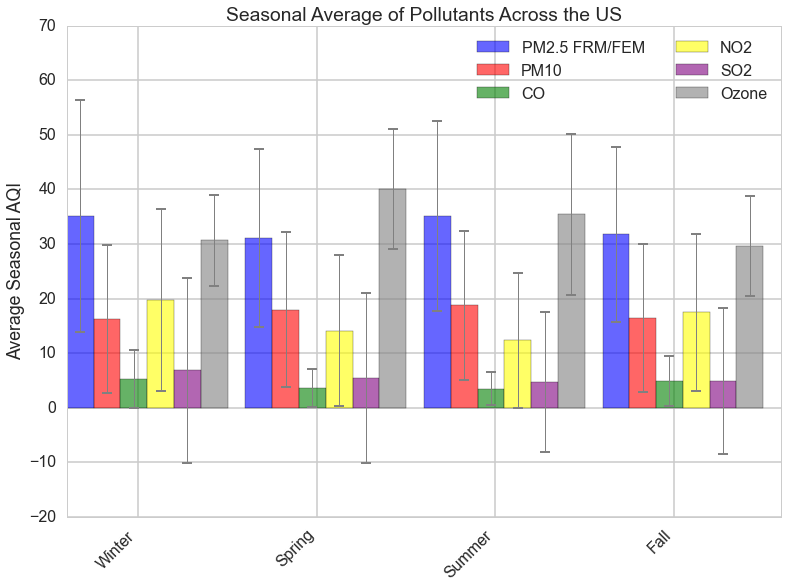

In [202]:
#Visualize the average pollutants by season
group = SeasonDat.groupby('season')
plotVals = group.mean()
plotError = group.std()
fig, ax1 = plt.subplots()
x=[0,1,2,3]
pm25_bar=plt.bar(x,[float(plotVals[plotVals.index=='Winter']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Fall']['AQI_PM25_FRMFEM'])],
                  width=.15,color='blue',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_PM25_FRMFEM']),2*float(plotError[plotError.index=='Spring']['AQI_PM25_FRMFEM']),
 2*float(plotError[plotError.index=='Summer']['AQI_PM25_FRMFEM']),2*float(plotError[plotError.index=='Fall']['AQI_PM25_FRMFEM'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

pm10_bar=plt.bar([i+.15 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_PM10']),float(plotVals[plotVals.index=='Spring']['AQI_PM10']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM10']),float(plotVals[plotVals.index=='Fall']['AQI_PM10'])],
                  width=.15,color='red',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_PM10']),2*float(plotError[plotError.index=='Spring']['AQI_PM10']),
 2*float(plotError[plotError.index=='Summer']['AQI_PM10']),2*float(plotError[plotError.index=='Fall']['AQI_PM10'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

co_bar=plt.bar([i+.3 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_CO']),float(plotVals[plotVals.index=='Spring']['AQI_CO']),
 float(plotVals[plotVals.index=='Summer']['AQI_CO']),float(plotVals[plotVals.index=='Fall']['AQI_CO'])],
                  width=.15,color='green',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_CO']),2*float(plotError[plotError.index=='Spring']['AQI_CO']),
 2*float(plotError[plotError.index=='Summer']['AQI_CO']),2*float(plotError[plotError.index=='Fall']['AQI_CO'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

no2_bar=plt.bar([i+.45 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_NO2']),float(plotVals[plotVals.index=='Spring']['AQI_NO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_NO2']),float(plotVals[plotVals.index=='Fall']['AQI_NO2'])],
                  width=.15,color='yellow',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_NO2']),2*float(plotError[plotError.index=='Spring']['AQI_NO2']),
 2*float(plotError[plotError.index=='Summer']['AQI_NO2']),2*float(plotError[plotError.index=='Fall']['AQI_NO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

so2_bar=plt.bar([i+.6 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_SO2']),float(plotVals[plotVals.index=='Spring']['AQI_SO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_SO2']),float(plotVals[plotVals.index=='Fall']['AQI_SO2'])],
                  width=.15,color='purple',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_SO2']),2*float(plotError[plotError.index=='Spring']['AQI_SO2']),
 2*float(plotError[plotError.index=='Summer']['AQI_SO2']),2*float(plotError[plotError.index=='Fall']['AQI_SO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

ozone_bar=plt.bar([i+.75 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_OZONE']),float(plotVals[plotVals.index=='Spring']['AQI_OZONE']),
 float(plotVals[plotVals.index=='Summer']['AQI_OZONE']),float(plotVals[plotVals.index=='Fall']['AQI_OZONE'])],
                  width=.15,color='grey',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_OZONE']),2*float(plotError[plotError.index=='Spring']['AQI_OZONE']),
 2*float(plotError[plotError.index=='Summer']['AQI_OZONE']),2*float(plotError[plotError.index=='Fall']['AQI_OZONE'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

plt.xticks([i+.4 for i in x],['Winter','Spring','Summer','Fall'],rotation=45,ha='right')
ax1.set_ylim(-20,70)
plt.ylabel('Average Seasonal AQI')
plt.legend((pm25_bar,pm10_bar,co_bar,no2_bar,so2_bar,ozone_bar),('PM2.5 FRM/FEM','PM10','CO','NO2','SO2','Ozone'),ncol=2)
plt.title('Seasonal Average of Pollutants Across the US')

Again, we see quite variable measurements as evidenced by the large error bars. It may be possible to see differences in pollution profiles between cities as there seems to be variation in the AQI's for each site. There is not a lot of seasonal trend for most pollutants. This suggests that perhaps looking at a yearly average for each site may be appropriate for analysis.

In [484]:
'''
SeasonDat = SeasonDat[pd.notnull(SeasonDat['PM25_FRMFEM'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['PM25_NOFRMFEM'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['PM10'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['TEMP'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['PRESS'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['RH'])]
#SeasonDat = SeasonDat[pd.notnull(SeasonDat['DP'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['CO'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['NO2'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['OZONE'])]
SeasonDat = SeasonDat[pd.notnull(SeasonDat['SO2'])]
SeasonDat[SeasonDat.season=='Fall'].shape
'''

(42, 27)

In [33]:
#Groupby identifiers and season
#We also create a month breakdown simultaneously
group = pm25.groupby(['Local Site Name','State Name','County Name','City Name','season'])
group2 = pm25.groupby(['Local Site Name','State Name','County Name','City Name','month'])
#Get mean of the observation
pollDat_s = group.mean()
pollDat_m = group2.mean()
#Pull all the relevant descriptors for the particular city
#along with the observation for PM2.5
pollDat_s['PM25_frmfem']=pollDat_s['Arithmetic Mean']
pollDat_m['PM25_frmfem']=pollDat_m['Arithmetic Mean']
#Get rid of extra stuff we're not interested in
pollDat_s.drop('Observation Count',axis=1,inplace=True)
pollDat_s.drop('Observation Percent',axis=1,inplace=True)
pollDat_s.drop('Arithmetic Mean',axis=1,inplace=True)
pollDat_s.drop('1st Max Value',axis=1,inplace=True)
pollDat_s.drop('1st Max Hour',axis=1,inplace=True)
pollDat_s.drop('AQI',axis=1,inplace=True)
pollDat_s.drop('Method Code',axis=1,inplace=True)
pollDat_s.drop('Parameter Code',axis=1,inplace=True)
pollDat_s.drop('POC',axis=1,inplace=True)
pollDat_m.drop('Observation Count',axis=1,inplace=True)
pollDat_m.drop('Observation Percent',axis=1,inplace=True)
pollDat_m.drop('Arithmetic Mean',axis=1,inplace=True)
pollDat_m.drop('1st Max Value',axis=1,inplace=True)
pollDat_m.drop('1st Max Hour',axis=1,inplace=True)
pollDat_m.drop('AQI',axis=1,inplace=True)
pollDat_m.drop('Method Code',axis=1,inplace=True)
pollDat_m.drop('Parameter Code',axis=1,inplace=True)
pollDat_m.drop('POC',axis=1,inplace=True)

**PM2.5_no_frmfem**

In [34]:
#Using PM2.5_no_frmfem


In [35]:
#Get the seasonal means
group = pm25_nofrmfem.groupby(['Local Site Name','season'])
group2 = pm25_nofrmfem.groupby(['Local Site Name','month'])
intmed = group.mean()
intmed2 = group2.mean()
intmed['PM25_no_frmfem']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['PM25_no_frmfem']]
intmed2['PM25_no_frmfem']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['PM25_no_frmfem']]

In [36]:
#Merge with the original data
pollDat_s = pd.merge(pollDat_s.reset_index(),intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_m = pd.merge(pollDat_m.reset_index(),intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()

**PM10**

In [39]:
group = pm10.groupby(['Local Site Name','season'])
group2 = pm10.groupby(['Local Site Name','month'])
intmed = group.mean()
intmed['PM10']=intmed['Arithmetic Mean']
intmed2 = group2.mean()
intmed2['PM10']=intmed2['Arithmetic Mean']
intmed=intmed.ix[:,['PM10']]
intmed2=intmed2.ix[:,['PM10']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

**Air Pressure**

In [40]:
group = press.groupby(['Local Site Name','season'])
group2 = press.groupby(['Local Site Name','month'])
intmed = group.mean()
intmed['Press']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['Press']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
intmed2 = group2.mean()
intmed2['Press']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['Press']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

**Temperature**

In [41]:
group = temp.groupby(['Local Site Name','season'])
intmed = group.mean()
intmed['Temp']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['Temp']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
group2 = temp.groupby(['Local Site Name','month'])
intmed2 = group2.mean()
intmed2['Temp']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['Temp']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

**Relative Humidity and Dewpoint**

In [44]:
group = rh.groupby(['Local Site Name','season'])
intmed = group.mean()
intmed['RH']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['RH']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
group2 = rh.groupby(['Local Site Name','month'])
intmed2 = group2.mean()
intmed2['RH']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['RH']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

In [45]:
group = dp.groupby(['Local Site Name','season'])
intmed = group.mean()
intmed['DP']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['DP']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
group2 = dp.groupby(['Local Site Name','month'])
intmed2 = group2.mean()
intmed2['DP']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['DP']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

**Wind**

In [46]:
group = wind.groupby(['Local Site Name','season'])
intmed = group.mean()
intmed['Wind']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['Wind']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
group2 = wind.groupby(['Local Site Name','month'])
intmed2 = group2.mean()
intmed2['Wind']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['Wind']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

**CO**

In [47]:
group = co.groupby(['Local Site Name','season'])
intmed = group.mean()
intmed['CO']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['CO']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
group2 = co.groupby(['Local Site Name','month'])
intmed2 = group2.mean()
intmed2['CO']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['CO']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

**NO2**

In [48]:
group = no2.groupby(['Local Site Name','season'])
intmed = group.mean()
intmed['NO2']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['NO2']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
group2 = no2.groupby(['Local Site Name','month'])
intmed2 = group2.mean()
intmed2['NO2']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['NO2']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

**Ozone**

In [49]:
group = ozone.groupby(['Local Site Name','season'])
intmed = group.mean()
intmed['Ozone']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['Ozone']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
group2 = ozone.groupby(['Local Site Name','month'])
intmed2 = group2.mean()
intmed2['Ozone']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['Ozone']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

**SO2**

In [50]:
group = so2.groupby(['Local Site Name','season'])
intmed = group.mean()
intmed['SO2']=intmed['Arithmetic Mean']
intmed=intmed.ix[:,['SO2']]
pollDat_s = pd.merge(pollDat_s,intmed.reset_index(),on=['Local Site Name','season'],how='outer').reset_index()
pollDat_s.drop('level_0',axis=1,inplace=True)
group2 = so2.groupby(['Local Site Name','month'])
intmed2 = group2.mean()
intmed2['SO2']=intmed2['Arithmetic Mean']
intmed2=intmed2.ix[:,['SO2']]
pollDat_m = pd.merge(pollDat_m,intmed2.reset_index(),on=['Local Site Name','month'],how='outer').reset_index()
pollDat_m.drop('level_0',axis=1,inplace=True)

No we have all the pollutant data into two dataframes, one broken down by season, `pollDat_s` and one broken down by month `pollDat_m`. We check the file and notice that there are many NaNs as some cities don't have all types of observations for each city. We will have to think carefully about how to deal with these missing values in downstream analysis.

In [53]:
pollDat_s.head(6)

,index,Local Site Name,State Name,County Name,City Name,season,State Code,County Code,Site Num,Latitude,Longitude,month,PM25_frmfem,PM25_no_frmfem,PM10,Press,Temp,RH,DP,Wind,CO,NO2,Ozone,SO2
0,0,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,Fall,18,147,9,38.167523,-86.983214,11.032258,8.867742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,Spring,18,147,9,38.167523,-86.983214,4.965517,9.279310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,Summer,18,147,9,38.167523,-86.983214,7.967742,12.970968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,Winter,18,147,9,38.167523,-86.983214,2.000000,11.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,FRANCIS SCHOOL East Providence,Rhode Island,Providence,East Providence,Fall,44,7,1010,41.841573,-71.360770,10.992509,6.052700,NaN,NaN,1011.878623,45.550666,73.482554,NaN,97.687185,0.253064,8.438933,0.021789,0.417302
5,5,FRANCIS SCHOOL East Providence,Rhode Island,Providence,East Providence,Spring,44,7,1010,41.841573,-71.360770,5.000000,5.345889,5.937931,NaN,1012.363553,59.151616,64.429746,NaN,93.208746,0.188207,4.475064,0.035278,0.270632


In [54]:
pollDat_m.head(6)

,index,Local Site Name,State Name,County Name,City Name,month,State Code,County Code,Site Num,Latitude,Longitude,PM25_frmfem,PM25_no_frmfem,PM10,Press,Temp,RH,DP,Wind,CO,NO2,Ozone,SO2
0,0,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,1,18,147,9,38.167523,-86.983214,8.340000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,2,18,147,9,38.167523,-86.983214,15.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,3,18,147,9,38.167523,-86.983214,12.340000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,4,18,147,9,38.167523,-86.983214,7.590000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,5,18,147,9,38.167523,-86.983214,9.480000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,"DAVID TURNHAM ELEMENTARY SCHOOL, Corner of Du...",Indiana,Spencer,Dale,6,18,147,9,38.167523,-86.983214,10.933333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we want to do some basic descriptive exploration of the data in each season to look for any overall seasonal trends. We need to break out the data into just the columns of interest and then subset the data into 4 different datasets, one for each season.

In [69]:
seasonalPlot=pollDat_s.ix[:,['Local Site Name','State Name','County Name','City Name','season','State Code','County Code','Site Num','Latitude','Longitude','PM25_frmfem','PM25_no_frmfem','PM10','CO','NO2','SO2','Ozone','Press','Temp','RH','DP','Wind']]

In [56]:
summer_test=seasonalPlot[seasonalPlot.season=='Summer']
winter_test=seasonalPlot[seasonalPlot.season=='Winter']
spring_test=seasonalPlot[seasonalPlot.season=='Spring']
fall_test=seasonalPlot[seasonalPlot.season=='Fall']

Let's check the number of cities we have data for in each season.

In [57]:
print "Number of summer cities: " + str(summer_test.shape[0])
print "Number of winter cities: " + str(winter_test.shape[0])
print "Number of fall cities: " + str(fall_test.shape[0])
print "Number of spring cities: " + str(spring_test.shape[0])

Number of summer cities: 2077
Number of winter cities: 2031
Number of fall cities: 1990
Number of spring cities: 2072


As a preliminary exploratory analysis, we can simply see how the mean values of each of the pollutants and weather variables changes over the years. Presumably this should match what other research has shown. We have to assume that there isn't a huge regional difference here which may or may not actually be reasonable given that we know certain cities have different effects. This is just a cursory look.

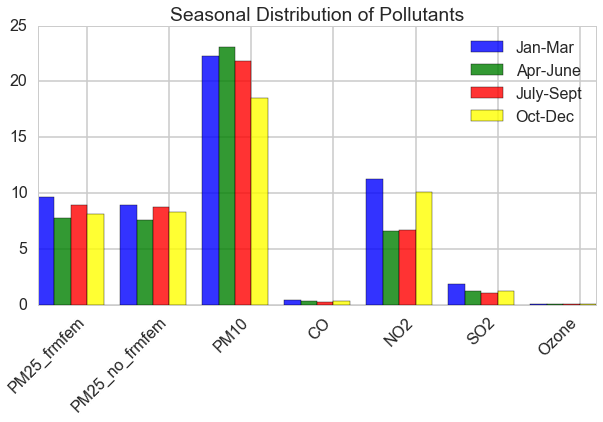

In [67]:
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6),tight_layout=True)
plt.figure(figsize=(10,5))
winterbar=plt.bar(range(len(winter_test.mean()))[5:12],winter_test.mean().values[5:12],width=.2,color='blue',alpha=.8)
plt.xticks(range(len(winter_test.mean()))[5:12],winter_test.mean().index[5:12],rotation=45,ha='right')
springbar=plt.bar([x+.2 for x in range(len(spring_test.mean()))[5:12]],spring_test.mean().values[5:12],width=.2,color='green',alpha=.8)
plt.xticks([x+.2 for x in range(len(spring_test.mean()))[5:12]],spring_test.mean().index[5:12],rotation=45,ha='right')
summerbar=plt.bar([x+.4 for x in range(len(summer_test.mean()))[5:12]],summer_test.mean().values[5:12],width=.2,color='red',alpha=.8)
plt.xticks([x+.4 for x in range(len(summer_test.mean()))[5:12]],summer_test.mean().index[5:12],rotation=45,ha='right')
fallbar=plt.bar([x+.6 for x in range(len(fall_test.mean()))[5:12]],fall_test.mean().values[5:12],width=.2,color='yellow',alpha=.8)
plt.xticks([x+.6 for x in range(len(fall_test.mean()))[5:12]],fall_test.mean().index[5:12],rotation=45,ha='right')
plt.legend((winterbar,springbar,summerbar,fallbar),('Jan-Mar','Apr-June','July-Sept','Oct-Dec'))
plt.title("Seasonal Distribution of Pollutants")

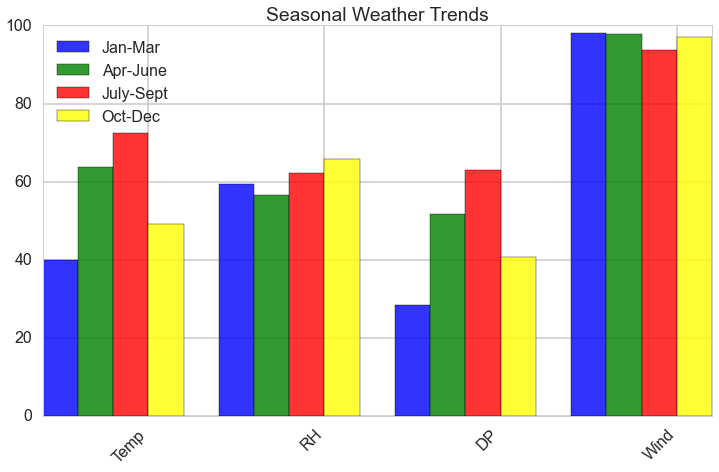

In [68]:
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6),tight_layout=True)
plt.figure(figsize=(12,7))
winterbar=plt.bar(range(len(winter_test.mean()))[13:18],winter_test.mean().values[13:18],width=.2,color='blue',alpha=.8)
plt.xticks(range(len(winter_test.mean()))[13:18],winter_test.mean().index[13:18],rotation=45,ha='right')
springbar=plt.bar([x+.2 for x in range(len(spring_test.mean()))[13:18]],spring_test.mean().values[13:18],width=.2,color='green',alpha=.8)
plt.xticks([x+.2 for x in range(len(spring_test.mean()))[13:18]],spring_test.mean().index[13:18],rotation=45,ha='right')
summerbar=plt.bar([x+.4 for x in range(len(summer_test.mean()))[13:18]],summer_test.mean().values[13:18],width=.2,color='red',alpha=.8)
plt.xticks([x+.4 for x in range(len(summer_test.mean()))[13:18]],summer_test.mean().index[13:18],rotation=45,ha='right')
fallbar=plt.bar([x+.6 for x in range(len(fall_test.mean()))[13:18]],fall_test.mean().values[13:18],width=.2,color='yellow',alpha=.8)
plt.xticks([x+.6 for x in range(len(fall_test.mean()))[13:18]],fall_test.mean().index[13:18],rotation=45,ha='right')
plt.legend((winterbar,springbar,summerbar,fallbar),('Jan-Mar','Apr-June','July-Sept','Oct-Dec'),loc='upper left')
plt.title('Seasonal Weather Trends')

We can also look at average changes in pollutants and weather over a monthly basis.

In [70]:
monthlyPlot=pollDat_m.ix[:,['Local Site Name','State Name','County Name','City Name','month','State Code','County Code','Site Num','Latitude','Longitude','PM25_frmfem','PM25_no_frmfem','PM10','CO','NO2','SO2','Ozone','Press','Temp','RH','DP','Wind']]

In [75]:
group = monthlyPlot.groupby('month')
plotVals = group.mean()

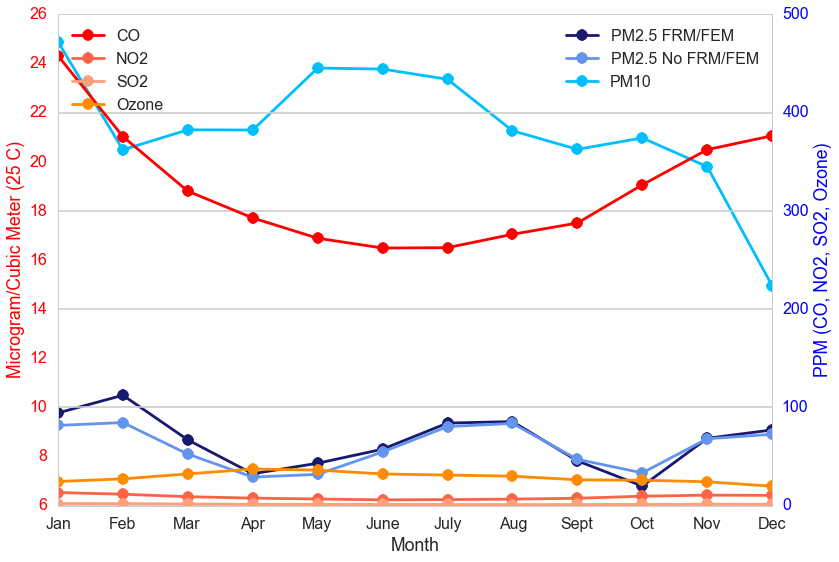

In [141]:
#Help from http://matplotlib.org/examples/api/two_scales.html for duel axis
#and coloring of axis labels
#Help from http://stackoverflow.com/questions/6682784/how-to-reduce-number-of-ticks-with-matplotlib
#to set axis ticks

colors = ["#191970", "#6495ed", "#00bfff"]
with sns.color_palette(colors):
    fig, ax1 = plt.subplots()
    plt.locator_params(nbins=12)
    plt.grid(False)
    ax1.plot(plotVals.PM25_frmfem,'o-',label='PM2.5 FRM/FEM')
    ax1.set_xticklabels(('Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'))
    ax1.set_xlabel('Month')
    ax1.plot(plotVals.PM25_no_frmfem,'o-',label='PM2.5 No FRM/FEM')
    ax1.plot(plotVals.PM10,'o-',label='PM10')
    for tl in ax1.get_yticklabels():
        tl.set_color('r')
    ax1.set_ylabel("Microgram/Cubic Meter (25 C)",color='r')
    ax1.legend(loc='upper right')

colors = ["#ff0000", "#ff6347", "#ffa07a",'#ff8c00']
with sns.color_palette(colors):
    ax2=ax1.twinx()
    co=ax2.plot(plotVals.CO*1000,'o-',label='CO')
    no2=ax2.plot(plotVals.NO2,'o-',label='NO2')
    so2=ax2.plot(plotVals.SO2,'o-',label='SO2')
    ozone=ax2.plot(plotVals.Ozone*1000,'o-',label='Ozone')
    ax2.set_ylabel('PPM (CO, NO2, SO2, Ozone)', color='b')
    for tl in ax2.get_yticklabels():
        tl.set_color('b')
    legend = ax2.legend(loc='upper left')
plt.show()


In [ ]:
"Temp (degree F); RH (% RH); DP (degree F); \nWind (knots); Pressure (Millibars)"

In [ ]:
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6),tight_layout=True)
plt.figure(figsize=(10,5))


#Hierarchical Clustering

In [43]:
summer_test=summer_test
df1= summer_test.ix[:,['PM25_frmfem','PM10','CO','SO2','NO2','Ozone']]
df1= df1.dropna(axis=0)

In [44]:
df1.shape

(55, 6)

In [47]:
#Code from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
import scipy.cluster.hierarchy as hac
df1= summer_test.ix[:,['PM25_frmfem','CO','SO2','NO2','Ozone']].dropna(axis=0)
X = np.array(df1)
Z = hac.linkage(X, 'average')

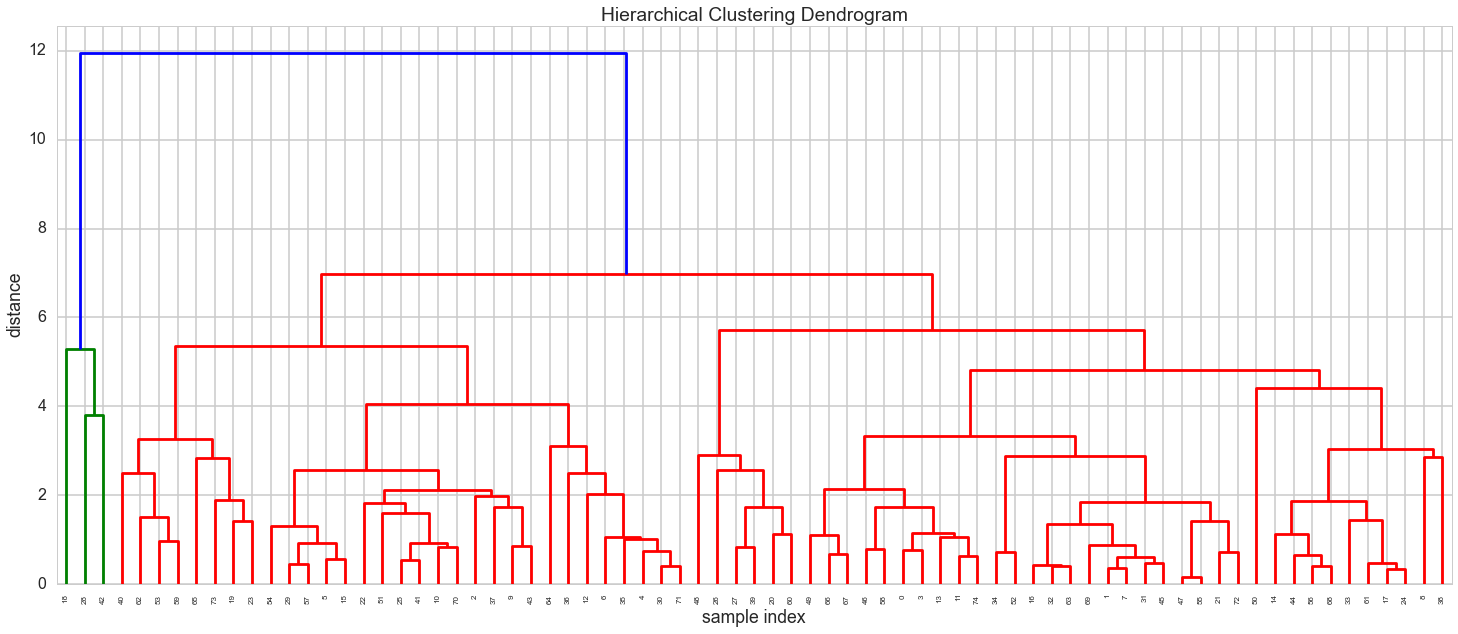

In [48]:
#Code from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [52]:
test.shape

(147, 3)